In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd '/home/deepk/filter-generation/modeling/Sequence-VAE'
!ls

/home/deepk/filter-generation/modeling/Sequence-VAE
data		 LICENSE  model.py	play_with_model.ipynb  train.py
filter_loss.py	 loss.py  models	__pycache__	       untitled.txt
filter_model.py  main.py  Pipfile	README.md	       utils.py
filter_train.py  media	  Pipfile.lock	settings.py


In [323]:
!python3 main.py

Epoch:  0
Training.......
^C
Traceback (most recent call last):
  File "main.py", line 72, in <module>
    train_losses = trainer.train(train_losses, epoch, training_setting["batch_size"], training_setting["clip"])
  File "/home/deepk/filter-generation/modeling/Sequence-VAE/train.py", line 29, in train
    x_hat_param, mu, log_var, z, states = self.model(source,source_lengths, states)
  File "/home/deepk/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/deepk/filter-generation/modeling/Sequence-VAE/model.py", line 113, in forward
    z, mean, log_var, hidden_encoder = self.encoder(packed_x_embed, maximum_padding_length, hidden_encoder)
  File "/home/deepk/filter-generation/modeling/Sequence-VAE/model.py", line 66, in encoder
    std = torch.exp(0.5 * log_var)   # e^(0.5 log_var) = var^0.5
KeyboardInterrupt


In [3]:
import torch
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from filter_loss import VAE_Loss
from filter_model import LSTM_VAE
from filter_train import FilterTrainer

# from settings import global_setting, model_setting, training_setting
from utils import plot_elbo
from tqdm import tqdm
# from utils import  interpolate, plot_elbo, get_latent_codes, visualize_latent_codes
torch.manual_seed(1000)

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# bptt = 60
vae_batch_size = 100
num_filters = 9
# embed_size = 300
hidden_size = 20
latent_size = 10
input_size = 25

In [6]:
# %cd '../../data'
# !unzip filters_complete.zip
# %cd '../modeling/Sequence-VAE'

In [7]:
a = torch.Tensor([[1,2,3],[3,4,5]])
b = torch.randperm(3)
print(b)
a[:,b]

tensor([1, 2, 0])


tensor([[2., 3., 1.],
        [4., 5., 3.]])

In [441]:
datapath = os.path.join('../..', 'data')
filterpath = os.path.join(datapath, '8_19')

# FILTER1 = torch.randn(5,5)
FILTER1 = torch.zeros(5,5)


def get_joint_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file), map_location=torch.device('cpu'))
    checkpoint = []
    for i in range(num_filters-1):
      checkpoint.append(filter['0.weight'][i][0])
    
    for perm in range(100):
        chkp = torch.stack(checkpoint, dim=0).detach().clone()
        p = torch.randperm(num_filters-1)
        chkp = chkp[p]
        data_pt = torch.cat([FILTER1.view(1,5,5),chkp])
    
#     c=torch.randperm(2)
#     t=t[r][:,c]
    
        weight_dataset.append(data_pt)
  return weight_dataset

num_images = len(os.listdir(filterpath))
dataset = get_joint_dataset()
dataset = torch.stack(dataset, dim=0)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

kwargs = {'num_workers': 1, 'pin_memory': True} 

points_cnt = vae_batch_size*int(len(dataset)/vae_batch_size)
train_dataset = dataset[:points_cnt]
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True, **kwargs)

1364it [00:06, 202.29it/s]


In [442]:
train_dataset.shape

torch.Size([136400, 9, 5, 5])

In [443]:
# from data.ptb import PTB

# train_data = PTB(data_dir="./data", split="train", create_data= False, max_sequence_length= bptt)
# test_data = PTB(data_dir="./data", split="test", create_data= False, max_sequence_length=bptt)

# # Batchify the data
# train_loader = torch.utils.data.DataLoader( dataset= train_data, batch_size=batch_size, shuffle= True)
# test_loader = torch.utils.data.DataLoader( dataset= test_data, batch_size= batch_size, shuffle= True)

# vocab_size = train_data.vocab_size

In [444]:
import matplotlib
import matplotlib.pyplot as plt

num_samples = 8
vmin, vmax = -2.5, 2.5
def visualise_joint_from_tensor(filters, interv=1):
  num_rows = filters.shape[0]
  num_filters = filters.shape[1]
  _, axarr = plt.subplots(num_rows, num_filters//interv, figsize=(int(5*((num_filters//interv)//8)), num_rows))
  plt.axis('off')
  for f in range(num_rows):
    filter = filters[f]
    for x in range(0,num_filters,interv):
      i = x//interv
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter[x].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))
  plt.show()  
  return filter

In [445]:
2500

2500

Training.......


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch   0 | elbo_loss 3.198519 | kl_loss 3.198519 | recons_loss 3.198519 


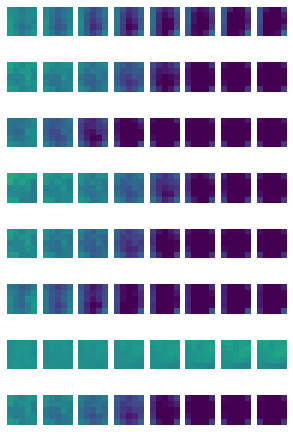

 20%|██        | 2/10 [00:27<01:50, 13.86s/it]

| epoch   1 | elbo_loss 2.045574 | kl_loss 2.045574 | recons_loss 2.045574 


 30%|███       | 3/10 [00:40<01:35, 13.60s/it]

| epoch   2 | elbo_loss 1.502191 | kl_loss 1.502191 | recons_loss 1.502191 


 40%|████      | 4/10 [00:55<01:24, 14.06s/it]

| epoch   3 | elbo_loss 1.229663 | kl_loss 1.229663 | recons_loss 1.229663 


 50%|█████     | 5/10 [01:08<01:09, 13.81s/it]

| epoch   4 | elbo_loss 1.184048 | kl_loss 1.184048 | recons_loss 1.184048 


 60%|██████    | 6/10 [01:22<00:55, 13.94s/it]

| epoch   5 | elbo_loss 1.143576 | kl_loss 1.143576 | recons_loss 1.143576 


 70%|███████   | 7/10 [01:36<00:41, 13.81s/it]

| epoch   6 | elbo_loss 1.133595 | kl_loss 1.133595 | recons_loss 1.133595 


 80%|████████  | 8/10 [01:49<00:27, 13.73s/it]

| epoch   7 | elbo_loss 1.132248 | kl_loss 1.132248 | recons_loss 1.132248 


 90%|█████████ | 9/10 [02:03<00:13, 13.57s/it]

| epoch   8 | elbo_loss 1.060478 | kl_loss 1.060478 | recons_loss 1.060478 


100%|██████████| 10/10 [02:15<00:00, 13.53s/it]


| epoch   9 | elbo_loss 0.980076 | kl_loss 0.980076 | recons_loss 0.980076 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  10 | elbo_loss 1.024012 | kl_loss 1.024012 | recons_loss 1.024012 


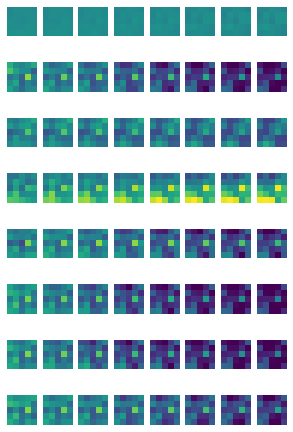

 20%|██        | 2/10 [00:23<01:31, 11.39s/it]

| epoch  11 | elbo_loss 1.004895 | kl_loss 1.004895 | recons_loss 1.004895 


 30%|███       | 3/10 [00:33<01:13, 10.54s/it]

| epoch  12 | elbo_loss 0.952380 | kl_loss 0.952380 | recons_loss 0.952380 


 40%|████      | 4/10 [00:41<00:57,  9.55s/it]

| epoch  13 | elbo_loss 0.958885 | kl_loss 0.958885 | recons_loss 0.958885 


 50%|█████     | 5/10 [00:54<00:54, 10.85s/it]

| epoch  14 | elbo_loss 0.968358 | kl_loss 0.968358 | recons_loss 0.968358 


 60%|██████    | 6/10 [01:07<00:47, 11.80s/it]

| epoch  15 | elbo_loss 0.948585 | kl_loss 0.948585 | recons_loss 0.948585 


 70%|███████   | 7/10 [01:21<00:37, 12.51s/it]

| epoch  16 | elbo_loss 0.916303 | kl_loss 0.916303 | recons_loss 0.916303 


 80%|████████  | 8/10 [01:34<00:24, 12.41s/it]

| epoch  17 | elbo_loss 0.883464 | kl_loss 0.883464 | recons_loss 0.883464 


 90%|█████████ | 9/10 [01:47<00:12, 12.79s/it]

| epoch  18 | elbo_loss 0.866085 | kl_loss 0.866085 | recons_loss 0.866085 


100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


| epoch  19 | elbo_loss 0.814476 | kl_loss 0.814476 | recons_loss 0.814476 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  20 | elbo_loss 0.823063 | kl_loss 0.823063 | recons_loss 0.823063 


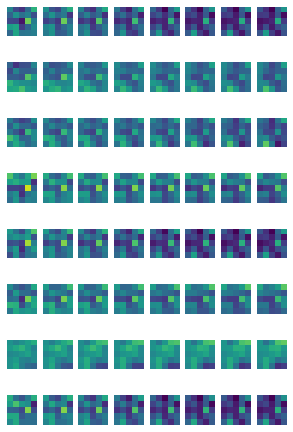

 20%|██        | 2/10 [00:28<01:52, 14.08s/it]

| epoch  21 | elbo_loss 0.812182 | kl_loss 0.812182 | recons_loss 0.812182 


 30%|███       | 3/10 [00:40<01:32, 13.16s/it]

| epoch  22 | elbo_loss 0.803177 | kl_loss 0.803177 | recons_loss 0.803177 


 40%|████      | 4/10 [00:53<01:18, 13.15s/it]

| epoch  23 | elbo_loss 0.776306 | kl_loss 0.776306 | recons_loss 0.776306 


 50%|█████     | 5/10 [01:07<01:06, 13.29s/it]

| epoch  24 | elbo_loss 0.798985 | kl_loss 0.798985 | recons_loss 0.798985 


 60%|██████    | 6/10 [01:19<00:52, 13.08s/it]

| epoch  25 | elbo_loss 0.766837 | kl_loss 0.766837 | recons_loss 0.766837 


 70%|███████   | 7/10 [01:32<00:38, 12.89s/it]

| epoch  26 | elbo_loss 0.755865 | kl_loss 0.755865 | recons_loss 0.755865 


 80%|████████  | 8/10 [01:46<00:26, 13.32s/it]

| epoch  27 | elbo_loss 0.764445 | kl_loss 0.764445 | recons_loss 0.764445 


 90%|█████████ | 9/10 [02:01<00:13, 13.74s/it]

| epoch  28 | elbo_loss 0.763331 | kl_loss 0.763331 | recons_loss 0.763331 


100%|██████████| 10/10 [02:16<00:00, 13.61s/it]


| epoch  29 | elbo_loss 0.812976 | kl_loss 0.812976 | recons_loss 0.812976 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  30 | elbo_loss 0.785530 | kl_loss 0.785530 | recons_loss 0.785530 


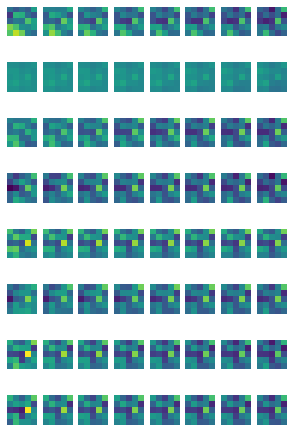

 20%|██        | 2/10 [00:27<01:49, 13.71s/it]

| epoch  31 | elbo_loss 0.761065 | kl_loss 0.761065 | recons_loss 0.761065 


 30%|███       | 3/10 [00:40<01:33, 13.36s/it]

| epoch  32 | elbo_loss 0.758520 | kl_loss 0.758520 | recons_loss 0.758520 


 40%|████      | 4/10 [00:50<01:13, 12.23s/it]

| epoch  33 | elbo_loss 0.777014 | kl_loss 0.777014 | recons_loss 0.777014 


 50%|█████     | 5/10 [01:05<01:05, 13.04s/it]

| epoch  34 | elbo_loss 0.776310 | kl_loss 0.776310 | recons_loss 0.776310 


 60%|██████    | 6/10 [01:18<00:52, 13.04s/it]

| epoch  35 | elbo_loss 0.777095 | kl_loss 0.777095 | recons_loss 0.777095 


 70%|███████   | 7/10 [01:31<00:39, 13.28s/it]

| epoch  36 | elbo_loss 0.792856 | kl_loss 0.792856 | recons_loss 0.792856 


 80%|████████  | 8/10 [01:42<00:25, 12.50s/it]

| epoch  37 | elbo_loss 0.784334 | kl_loss 0.784334 | recons_loss 0.784334 


 90%|█████████ | 9/10 [01:55<00:12, 12.74s/it]

| epoch  38 | elbo_loss 0.787433 | kl_loss 0.787433 | recons_loss 0.787433 


100%|██████████| 10/10 [02:08<00:00, 12.83s/it]


| epoch  39 | elbo_loss 0.791841 | kl_loss 0.791841 | recons_loss 0.791841 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  40 | elbo_loss 0.795053 | kl_loss 0.795053 | recons_loss 0.795053 


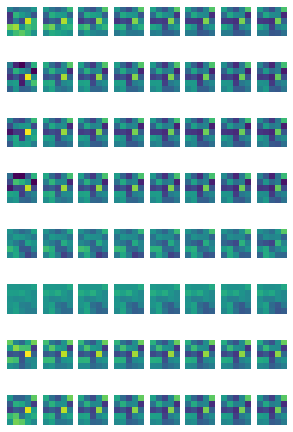

 20%|██        | 2/10 [00:26<01:46, 13.31s/it]

| epoch  41 | elbo_loss 0.784654 | kl_loss 0.784654 | recons_loss 0.784654 


 30%|███       | 3/10 [00:41<01:37, 13.88s/it]

| epoch  42 | elbo_loss 0.765213 | kl_loss 0.765213 | recons_loss 0.765213 


 40%|████      | 4/10 [00:49<01:11, 11.90s/it]

| epoch  43 | elbo_loss 0.721517 | kl_loss 0.721517 | recons_loss 0.721517 


 50%|█████     | 5/10 [01:02<01:00, 12.12s/it]

| epoch  44 | elbo_loss 0.763030 | kl_loss 0.763030 | recons_loss 0.763030 


 60%|██████    | 6/10 [01:15<00:49, 12.30s/it]

| epoch  45 | elbo_loss 0.769483 | kl_loss 0.769483 | recons_loss 0.769483 


 70%|███████   | 7/10 [01:25<00:34, 11.64s/it]

| epoch  46 | elbo_loss 0.747370 | kl_loss 0.747370 | recons_loss 0.747370 


 80%|████████  | 8/10 [01:36<00:23, 11.55s/it]

| epoch  47 | elbo_loss 0.789464 | kl_loss 0.789464 | recons_loss 0.789464 


 90%|█████████ | 9/10 [01:49<00:12, 12.04s/it]

| epoch  48 | elbo_loss 0.756513 | kl_loss 0.756513 | recons_loss 0.756513 


100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


| epoch  49 | elbo_loss 0.744723 | kl_loss 0.744723 | recons_loss 0.744723 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  50 | elbo_loss 0.749402 | kl_loss 0.749402 | recons_loss 0.749402 


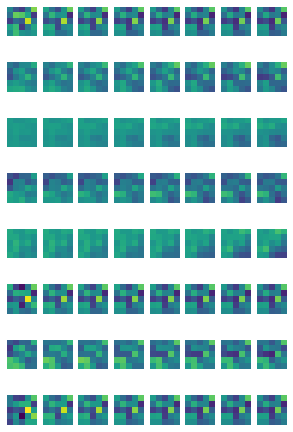

 20%|██        | 2/10 [00:23<01:33, 11.70s/it]

| epoch  51 | elbo_loss 0.779470 | kl_loss 0.779470 | recons_loss 0.779470 


 30%|███       | 3/10 [00:36<01:27, 12.46s/it]

| epoch  52 | elbo_loss 0.771008 | kl_loss 0.771008 | recons_loss 0.771008 


 40%|████      | 4/10 [00:49<01:15, 12.55s/it]

| epoch  53 | elbo_loss 0.771867 | kl_loss 0.771867 | recons_loss 0.771867 


 50%|█████     | 5/10 [01:02<01:03, 12.71s/it]

| epoch  54 | elbo_loss 0.744300 | kl_loss 0.744300 | recons_loss 0.744300 


 60%|██████    | 6/10 [01:14<00:49, 12.36s/it]

| epoch  55 | elbo_loss 0.791140 | kl_loss 0.791140 | recons_loss 0.791140 


 70%|███████   | 7/10 [01:28<00:39, 13.09s/it]

| epoch  56 | elbo_loss 0.788605 | kl_loss 0.788605 | recons_loss 0.788605 


 80%|████████  | 8/10 [01:41<00:25, 12.83s/it]

| epoch  57 | elbo_loss 0.758289 | kl_loss 0.758289 | recons_loss 0.758289 


 90%|█████████ | 9/10 [01:52<00:12, 12.33s/it]

| epoch  58 | elbo_loss 0.752769 | kl_loss 0.752769 | recons_loss 0.752769 


100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


| epoch  59 | elbo_loss 0.772767 | kl_loss 0.772767 | recons_loss 0.772767 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  60 | elbo_loss 0.815519 | kl_loss 0.815519 | recons_loss 0.815519 


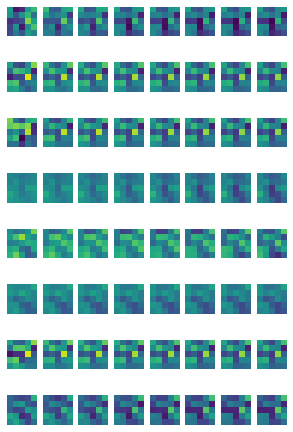

 20%|██        | 2/10 [00:26<01:46, 13.25s/it]

| epoch  61 | elbo_loss 0.784279 | kl_loss 0.784279 | recons_loss 0.784279 


 30%|███       | 3/10 [00:39<01:32, 13.23s/it]

| epoch  62 | elbo_loss 0.777824 | kl_loss 0.777824 | recons_loss 0.777824 


 40%|████      | 4/10 [00:51<01:17, 12.90s/it]

| epoch  63 | elbo_loss 0.770616 | kl_loss 0.770616 | recons_loss 0.770616 


 50%|█████     | 5/10 [01:03<01:01, 12.30s/it]

| epoch  64 | elbo_loss 0.759422 | kl_loss 0.759422 | recons_loss 0.759422 


 60%|██████    | 6/10 [01:17<00:52, 13.14s/it]

| epoch  65 | elbo_loss 0.787570 | kl_loss 0.787570 | recons_loss 0.787570 


 70%|███████   | 7/10 [01:29<00:38, 12.77s/it]

| epoch  66 | elbo_loss 0.765794 | kl_loss 0.765794 | recons_loss 0.765794 


 80%|████████  | 8/10 [01:40<00:24, 12.17s/it]

| epoch  67 | elbo_loss 0.769932 | kl_loss 0.769932 | recons_loss 0.769932 


 90%|█████████ | 9/10 [01:54<00:12, 12.60s/it]

| epoch  68 | elbo_loss 0.775001 | kl_loss 0.775001 | recons_loss 0.775001 


100%|██████████| 10/10 [02:07<00:00, 12.72s/it]


| epoch  69 | elbo_loss 0.778492 | kl_loss 0.778492 | recons_loss 0.778492 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  70 | elbo_loss 0.766960 | kl_loss 0.766960 | recons_loss 0.766960 


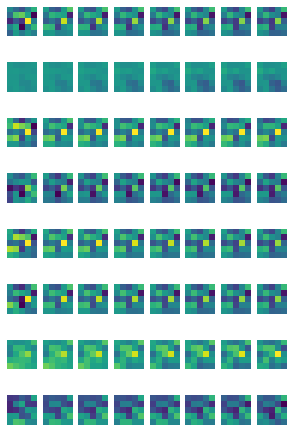

 20%|██        | 2/10 [00:26<01:49, 13.65s/it]

| epoch  71 | elbo_loss 0.755079 | kl_loss 0.755079 | recons_loss 0.755079 


 30%|███       | 3/10 [00:40<01:36, 13.77s/it]

| epoch  72 | elbo_loss 0.754553 | kl_loss 0.754553 | recons_loss 0.754553 


 40%|████      | 4/10 [00:55<01:24, 14.15s/it]

| epoch  73 | elbo_loss 0.756428 | kl_loss 0.756428 | recons_loss 0.756428 


 50%|█████     | 5/10 [01:07<01:07, 13.44s/it]

| epoch  74 | elbo_loss 0.757707 | kl_loss 0.757707 | recons_loss 0.757707 


 60%|██████    | 6/10 [01:20<00:52, 13.07s/it]

| epoch  75 | elbo_loss 0.762244 | kl_loss 0.762244 | recons_loss 0.762244 


 70%|███████   | 7/10 [01:31<00:37, 12.37s/it]

| epoch  76 | elbo_loss 0.756132 | kl_loss 0.756132 | recons_loss 0.756132 


 80%|████████  | 8/10 [01:44<00:25, 12.73s/it]

| epoch  77 | elbo_loss 0.755244 | kl_loss 0.755244 | recons_loss 0.755244 


 90%|█████████ | 9/10 [01:57<00:12, 12.86s/it]

| epoch  78 | elbo_loss 0.751358 | kl_loss 0.751358 | recons_loss 0.751358 


100%|██████████| 10/10 [02:09<00:00, 12.97s/it]


| epoch  79 | elbo_loss 0.765664 | kl_loss 0.765664 | recons_loss 0.765664 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  80 | elbo_loss 0.781294 | kl_loss 0.781294 | recons_loss 0.781294 


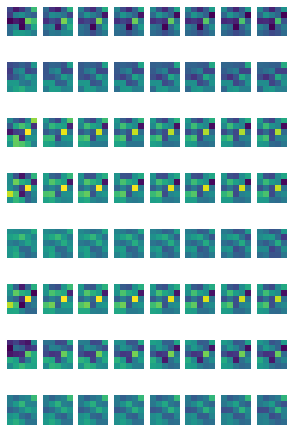

 20%|██        | 2/10 [00:31<02:03, 15.50s/it]

| epoch  81 | elbo_loss 0.785068 | kl_loss 0.785068 | recons_loss 0.785068 


 30%|███       | 3/10 [00:45<01:46, 15.21s/it]

| epoch  82 | elbo_loss 0.768841 | kl_loss 0.768841 | recons_loss 0.768841 


 40%|████      | 4/10 [00:59<01:27, 14.61s/it]

| epoch  83 | elbo_loss 0.745537 | kl_loss 0.745537 | recons_loss 0.745537 


 50%|█████     | 5/10 [01:11<01:08, 13.72s/it]

| epoch  84 | elbo_loss 0.762172 | kl_loss 0.762172 | recons_loss 0.762172 


 60%|██████    | 6/10 [01:26<00:55, 14.00s/it]

| epoch  85 | elbo_loss 0.756177 | kl_loss 0.756177 | recons_loss 0.756177 


 70%|███████   | 7/10 [01:40<00:41, 13.93s/it]

| epoch  86 | elbo_loss 0.737656 | kl_loss 0.737656 | recons_loss 0.737656 


 80%|████████  | 8/10 [01:52<00:27, 13.51s/it]

| epoch  87 | elbo_loss 0.770017 | kl_loss 0.770017 | recons_loss 0.770017 


 90%|█████████ | 9/10 [02:03<00:12, 12.80s/it]

| epoch  88 | elbo_loss 0.752141 | kl_loss 0.752141 | recons_loss 0.752141 


100%|██████████| 10/10 [02:17<00:00, 13.76s/it]


| epoch  89 | elbo_loss 0.837593 | kl_loss 0.837593 | recons_loss 0.837593 


  0%|          | 0/10 [00:00<?, ?it/s]

| epoch  90 | elbo_loss 0.728092 | kl_loss 0.728092 | recons_loss 0.728092 


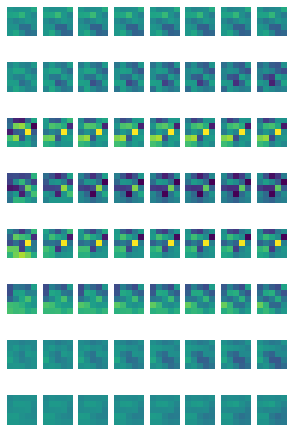

 20%|██        | 2/10 [00:28<01:51, 13.96s/it]

| epoch  91 | elbo_loss 0.761887 | kl_loss 0.761887 | recons_loss 0.761887 


 30%|███       | 3/10 [00:41<01:35, 13.67s/it]

| epoch  92 | elbo_loss 0.760972 | kl_loss 0.760972 | recons_loss 0.760972 


 40%|████      | 4/10 [00:55<01:23, 13.90s/it]

| epoch  93 | elbo_loss 0.774684 | kl_loss 0.774684 | recons_loss 0.774684 


 50%|█████     | 5/10 [01:09<01:09, 14.00s/it]

| epoch  94 | elbo_loss 0.775343 | kl_loss 0.775343 | recons_loss 0.775343 


 60%|██████    | 6/10 [01:23<00:55, 13.98s/it]

| epoch  95 | elbo_loss 0.750728 | kl_loss 0.750728 | recons_loss 0.750728 


 70%|███████   | 7/10 [01:39<00:43, 14.42s/it]

| epoch  96 | elbo_loss 0.770676 | kl_loss 0.770676 | recons_loss 0.770676 


 80%|████████  | 8/10 [01:52<00:27, 13.97s/it]

| epoch  97 | elbo_loss 0.753091 | kl_loss 0.753091 | recons_loss 0.753091 


 90%|█████████ | 9/10 [02:05<00:13, 13.85s/it]

| epoch  98 | elbo_loss 0.667815 | kl_loss 0.667815 | recons_loss 0.667815 


100%|██████████| 10/10 [02:18<00:00, 13.87s/it]

| epoch  99 | elbo_loss 0.660794 | kl_loss 0.660794 | recons_loss 0.660794 


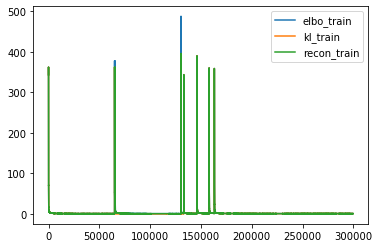

In [448]:
lr = 0.001
epochs = 100
clip = 0.25

model = LSTM_VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)

Loss = VAE_Loss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

trainer = FilterTrainer(train_loader, model, Loss, optimizer)

# train_losses = []
# test_losses = []
print("Training.......")
interval = 10
for ep in range(epochs//interval):
    for it in tqdm(range(interval)):
    #     print("Epoch: ", epoch)
        epoch = ep*interval + it
        train_losses = trainer.train(train_losses, epoch, vae_batch_size, clip)

        if epoch % interval == 0:
            sample = model.inference(num_samples,num_filters-1, FILTER1.view(1,1,-1).to(device))
            sample = sample.view(sample.shape[:-1]+tuple([5,5]))
            visualise_joint_from_tensor(sample)
#     print("Testing.......")
#     test_losses = trainer.test(test_losses, epoch, batch_size)


plot_elbo(train_losses, "train")
# plot_elbo(test_losses, "test")

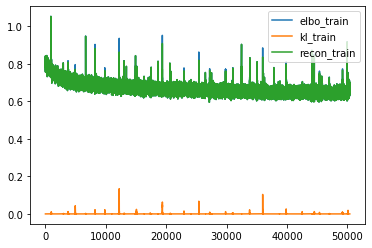

In [362]:
plot_elbo(train_losses[80000:], "train")

In [105]:
# epochs = 1

# model2 = LSTM_VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)
# Loss2 = VAE_Loss()
# optimizer2 = torch.optim.Adam(model.parameters(), lr= lr)
# trainer2 = FilterTrainer(train_loader, model2, Loss2, optimizer2)

# train_losses1 = []
# print("Training.......")
# for epoch in range(epochs):
#     train_losses1 = trainer.train(train_losses, epoch, vae_batch_size, clip)
# plot_elbo(train_losses1, "train")

In [450]:
MODEL_SAVE_PATH = "./models/filter_lstm/shuffle_100_recon_st.pt"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
FILTER_SAVE_PATH = "./models/filter_lstm/filter.pt"
torch.save(FILTER1, FILTER_SAVE_PATH)

In [218]:
# train_losses = trainer.train(train_losses, epoch, vae_batch_size, clip)
# model.forward
h = model.init_hidden(1)
x = train_dataset[1].view(1,9,-1).to(device)
x_hat,_,_,_,_ = model(x, h)
torch.abs(x).mean(), torch.sum(torch.square(x_hat-x))

(tensor(0.9879, device='cuda:0'),
 tensor(1.1226, device='cuda:0', grad_fn=<SumBackward0>))

## Inference

In [286]:
model = LSTM_VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)
MODEL_SAVE_PATH = "./models/filter_lstm/5000_Recon_st.pt"
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# torch.save(model.state_dict(), MODEL_SAVE_PATH)
# FILTER_SAVE_PATH = "./models/filter_lstm_vae_fixed_st_filter.pt"
# MODEL_SAVE_PATH = "./models/filter_lstm/5000_recon_st.pt"
FILTER1 = torch.load(FILTER_SAVE_PATH, map_location=torch.device('cpu'))
model.eval()

LSTM_VAE(
  (encoder_lstm): LSTM(25, 20, batch_first=True)
  (mean): Linear(in_features=20, out_features=10, bias=True)
  (log_variance): Linear(in_features=20, out_features=10, bias=True)
  (init_hidden_decoder): Linear(in_features=10, out_features=20, bias=True)
  (decoder_lstm): LSTM(25, 20, batch_first=True)
  (output): Linear(in_features=20, out_features=25, bias=True)
)

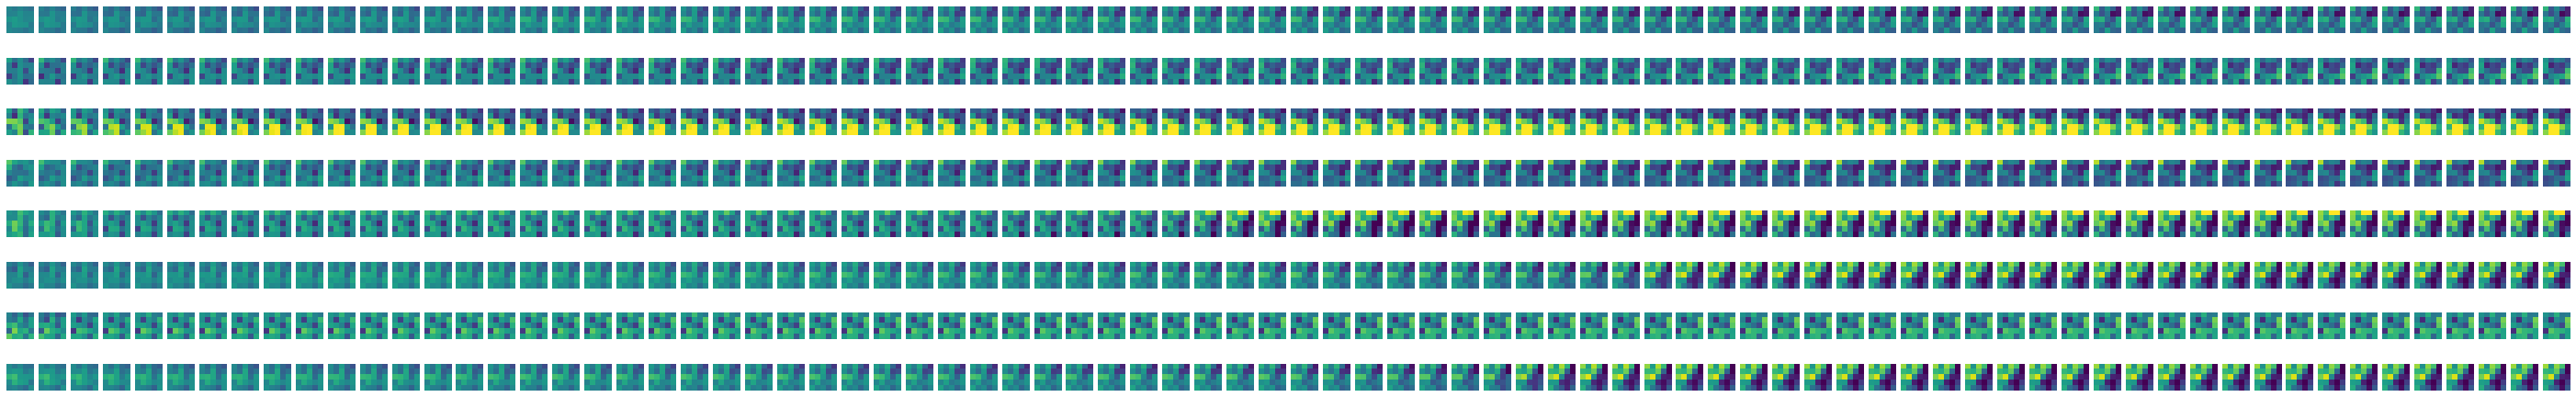

In [305]:
# z1 = torch.randn(1,1,latent_size).to(device)
torch.manual_seed(1000)
num_samples = 8
sample = model.inference(num_samples,800,FILTER1.view(1,1,-1).to(device))
sample = sample.view(sample.shape[:-1]+tuple([5,5]))
fils = visualise_joint_from_tensor(sample,10)
# print(sample.shape)

In [8]:
a=torch.Tensor([[0,1,2,3,4,5,6,7,8,9])
a[0:10:2]

tensor([0., 2., 4., 6., 8.])

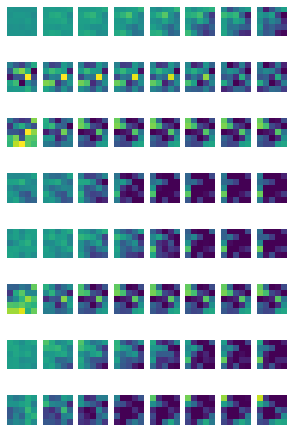

In [455]:
# z1 = torch.randn(1,1,latent_size).to(device)
torch.manual_seed(1000)
num_samples = 8
sample = model.inference(num_samples,80,FILTER1.view(1,1,-1).to(device))
sample = sample.view(sample.shape[:-1]+tuple([5,5]))
fils = visualise_joint_from_tensor(sample,10)
# print(sample.shape)

In [311]:
sample.shape

torch.Size([8, 80, 5, 5])

torch.Size([8, 8, 5, 5])


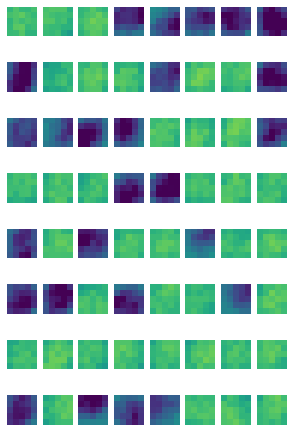

In [320]:
# filt1 = [FILTER1 for i in range(8)]
# filt1 = torch.stack(filt1,dim=0)
filt1 = FILTER1.repeat(5,8,1,1)
filt1 = train_dataset[6:14][:,1:]
print(filt1.shape)
filter = visualise_joint_from_tensor(filt1,1)

In [53]:
# for epoch in range(epochs):
#     overall_loss = 0
for batch_idx, x in enumerate(train_loader):
    x = x.view(x.shape[:-1]+tuple([-1]))
    x = x.to(device)
    print(x.shape)
    

torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])
torch.Size([100, 8, 5, 5])


In [114]:
z1 = torch.randn(1,1,latent_size).to(device)
input = torch.randn(1,1,25).to(device)
hidden = model.init_hidden_decoder(z1)
hidden = (hidden, hidden)
output,hidden = model.decoder_lstm(input, hidden)
output = model.output(output)
print(output, output.shape)


tensor([[[ 0.3064, -0.8971, -1.4641, -0.8707,  1.4352, -1.0966, -0.5364,
          -0.8153, -0.9454,  0.1941, -0.4393,  0.0346,  0.1608, -0.4449,
           0.0644, -0.6503, -0.8091, -0.9273, -0.6199, -0.9162, -0.2964,
          -0.6380, -1.0651,  0.3995, -0.0924]]], device='cuda:0',
       grad_fn=<AddBackward0>) torch.Size([1, 1, 25])
